In [175]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from matplotlib.pyplot import figure

In [176]:
df = pd.read_csv("../data/bike_sharing_data.csv")

### Creating New Features

In [177]:
df["date"] = df.datetime.apply(lambda x : x.split()[0])
df["hour"] = df.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
df["year"] = df.datetime.apply(lambda x : x.split()[0].split("-")[0])
df["weekday"] = df.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
df["month"] = df.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [178]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,5,1


### Data Imputation

![](../readme_images/5.png)

1. Get rid of columns with NA values
2. Impute using mean/median/mode depending on context
3. Build a simple prediction model to impute
4. Replace with 0

In [179]:
from sklearn.ensemble import RandomForestRegressor

dfWind0 = df[df["windspeed"]==0]
dfWindNot0 = df[df["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dfWindNot0[windColumns], dfWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dfWind0[windColumns])
dfWind0["windspeed"] = wind0Values
df = dfWindNot0.append(dfWind0)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

In [180]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011-01-01,5,2011,5,1
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,2011-01-01,10,2011,5,1
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,2011-01-01,11,2011,5,1
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,2011-01-01,12,2011,5,1
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,2011-01-01,13,2011,5,1


### Dealing with non-numerical Data

In [181]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered", "atemp"]
for var in categoricalFeatureNames:
    df[var] = df[var].astype("category")

## Model Training

At this point we have a good idea of what our data and features look like. Next thing we need to know is how well does our model need to perform.

![](../readme_images/6.png)

### Splitting into training and test set

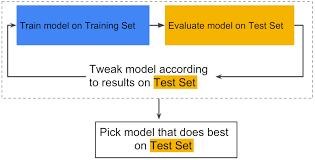

In [183]:
df = df[pd.notnull(df['count'])].sort_values(by=["datetime"])
df_train = df[:-2000]
df_test = df[-2000:]

x_train  = df_train.drop(dropFeatures,axis=1)
y_train = df_train["count"]

x_test = df_test.drop(dropFeatures,axis=1)
y_test = df_test['count']

In [184]:
print(x_train.shape)
x_train.head()

(8886, 11)


,season,holiday,workingday,weather,temp,humidity,windspeed,hour,year,weekday,month
9573,1,0,0,1,9.84,81,11.30089,0,2011,5,1
9574,1,0,0,1,9.02,80,14.30115,1,2011,5,1
9575,1,0,0,1,9.02,80,14.30115,2,2011,5,1
9576,1,0,0,1,9.84,75,6.90167,3,2011,5,1
9577,1,0,0,1,9.84,75,6.90167,4,2011,5,1


In [185]:
print(x_test.shape)
x_test.head()

(2000, 11)


,season,holiday,workingday,weather,temp,humidity,windspeed,hour,year,weekday,month
7841,3,0,0,1,31.16,40,8.99810,15,2012,6,8
7842,3,0,0,1,31.16,40,7.00150,16,2012,6,8
10618,3,0,0,1,32.80,33,11.74979,17,2012,6,8
7843,3,0,0,1,31.98,35,7.00150,18,2012,6,8
7844,3,0,0,1,30.34,40,8.99810,19,2012,6,8


### Training Models

In [188]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
import numpy as np
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

##### Choosing a metric

![](https://i.stack.imgur.com/83BUy.png)

In [192]:
def mean_absolute_percentage_error(y_true, y_pred): 
    
#     y_true, y_pred = check_arrays(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

#### (Multivariate) Linear Regression Model

![](https://www.jmp.com/en_hk/statistics-knowledge-portal/what-is-multiple-regression/fitting-multiple-regression-model/_jcr_content/par/styledcontainer_2069/par/lightbox_4130/lightboxImage.img.png/1548704005203.png)

![](https://usercontent1.hubstatic.com/6177878_f520.jpg)

In [197]:
# Initialize logistic regression model
linreg_model = LinearRegression(normalize=True)

# Train the model
linreg_model.fit(X = x_train, y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [198]:
training_predictions = linreg_model.predict(x_train)

#Training Error
mean_absolute_percentage_error(y_train, training_predictions)

340.5093722699076

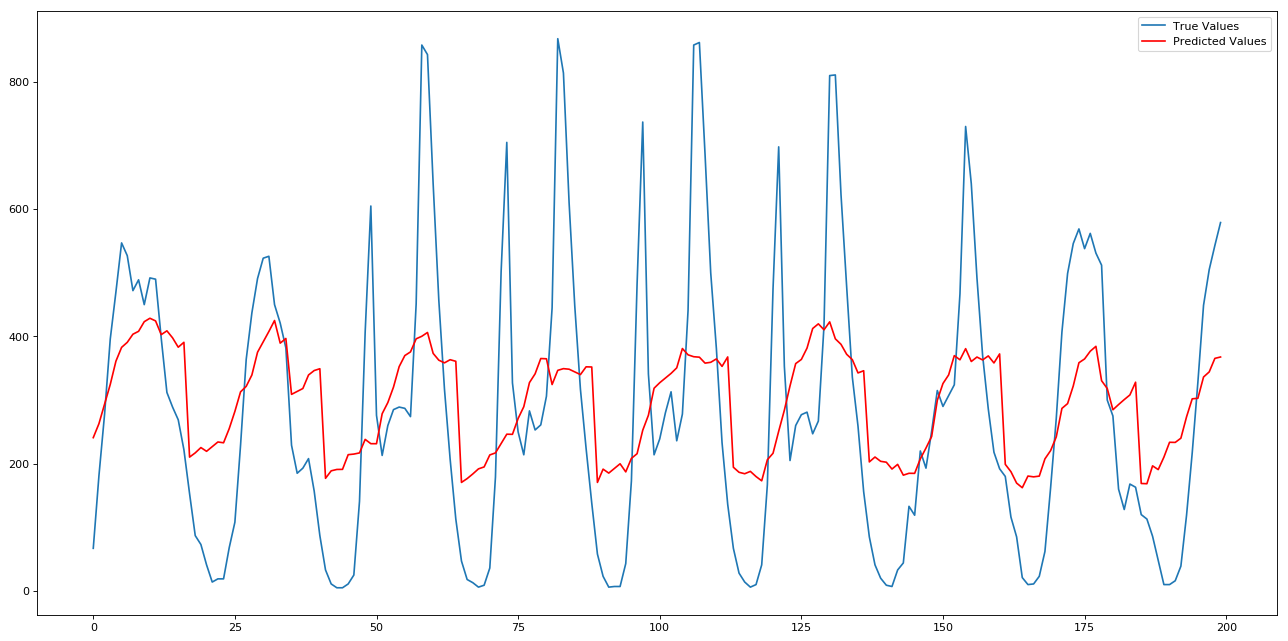

In [199]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_train.values[-view_number:], label='True Values')
plt.plot(training_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

In [146]:
test_predictions = linreg_model.predict(x_test)
mean_absolute_percentage_error(y_test, test_predictions)

347.8005883485902

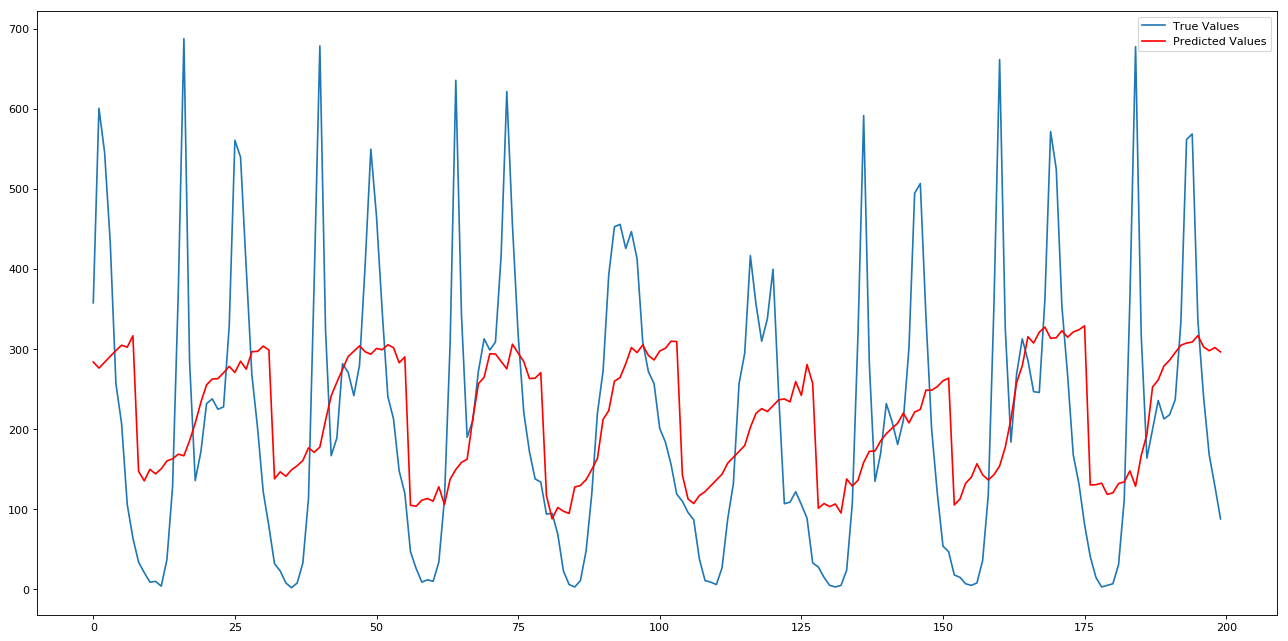

In [147]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_test.values[-view_number:], label='True Values')
plt.plot(test_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

#### Decision Tree Model

![](https://media.geeksforgeeks.org/wp-content/cdn-uploads/Decision_Tree-2.png)

In [148]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()
dt_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [149]:
training_predictions = dt_model.predict(X= x_train)
mean_absolute_percentage_error(y_train, training_predictions)

0.03961577797093973

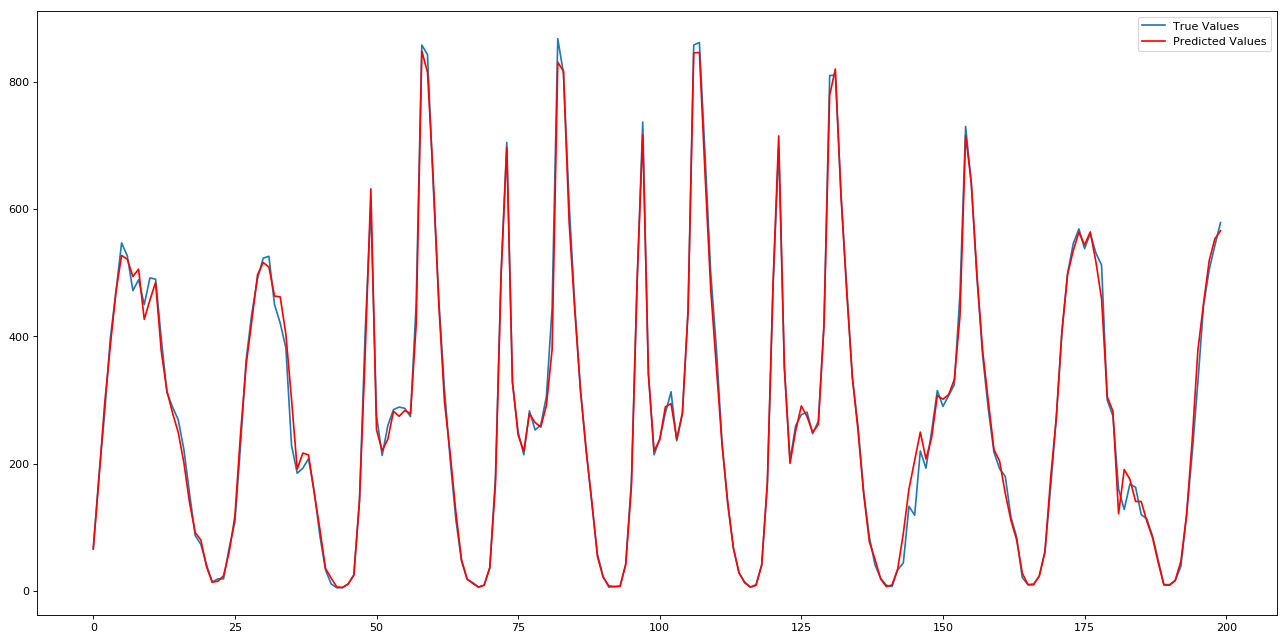

In [191]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_train.values[-view_number:], label='True Values')
plt.plot(training_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

In [151]:
test_predictions = dt_model.predict(X= x_test)
mean_absolute_percentage_error(y_test, test_predictions)

36.4491248730199

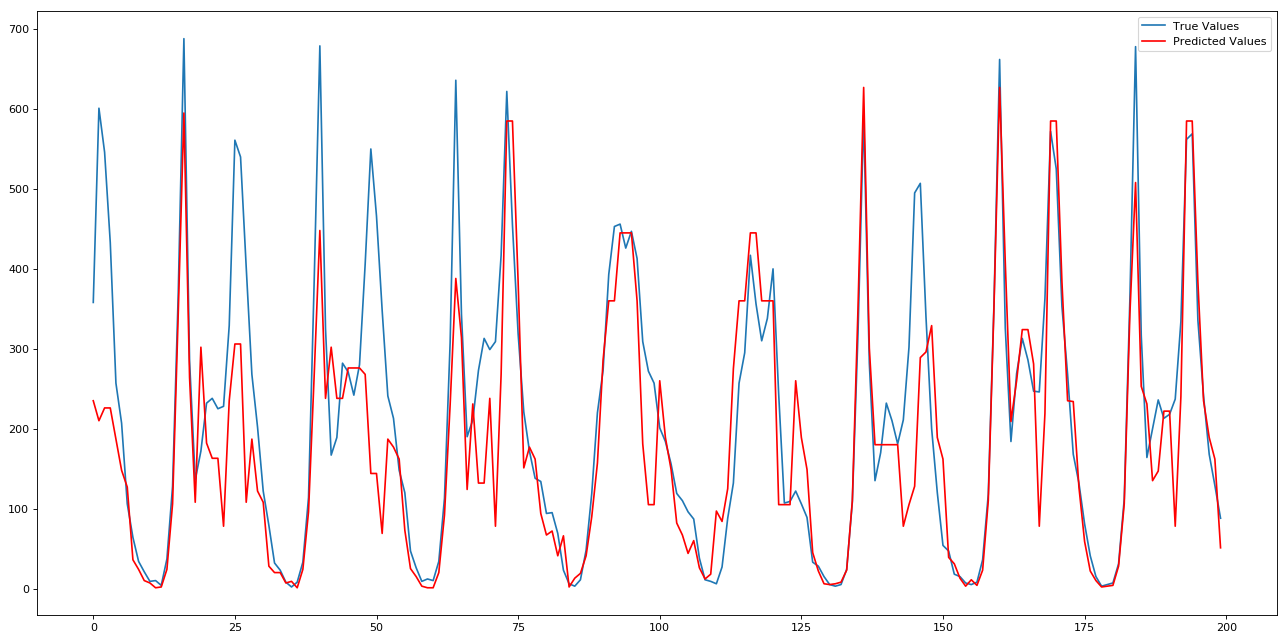

In [152]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_test.values[-view_number:], label='True Values')
plt.plot(test_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

#### Reducing Overfitting by Reducing Model Complexity

In [200]:
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(x_train, y_train)

training_predictions = dt_model.predict(X= x_train)
mean_absolute_percentage_error(y_train, training_predictions)

27.22719938969967

In [202]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(dt_model, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

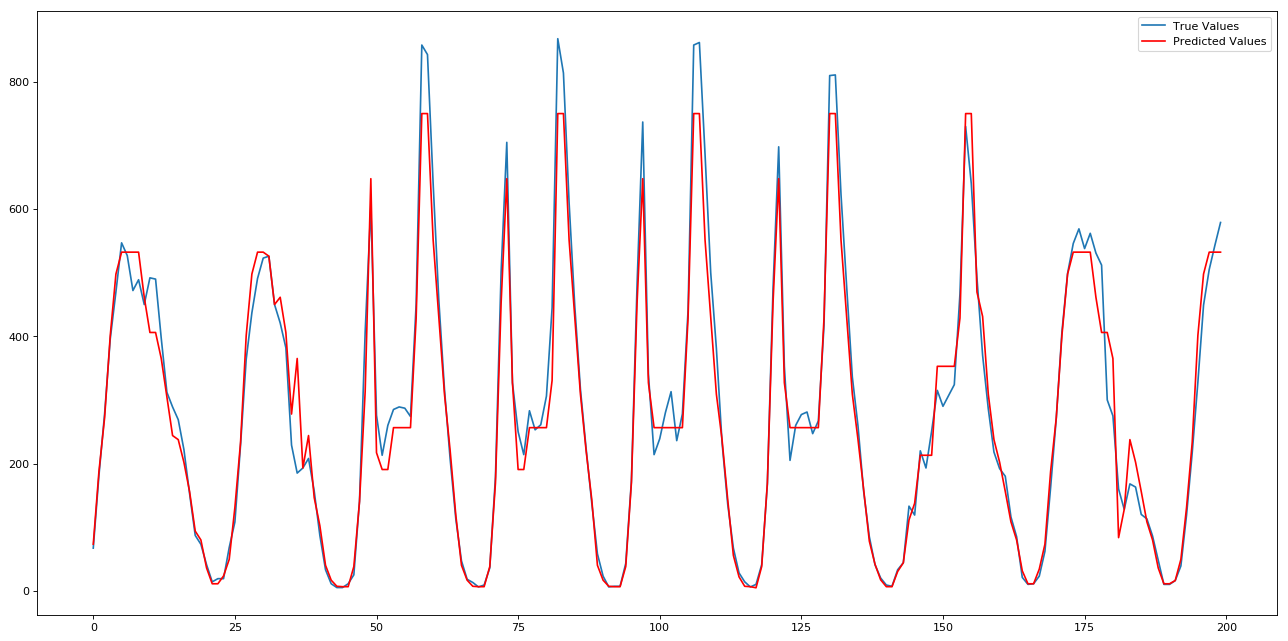

In [203]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_train.values[-view_number:], label='True Values')
plt.plot(training_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

In [204]:
test_predictions = dt_model.predict(X= x_test)
mean_absolute_percentage_error(y_test, test_predictions)

35.12091553471574

#### RandomForest Model

![](https://www.researchgate.net/profile/Evaldas_Vaiciukynas/publication/301638643/figure/fig1/AS:355471899807744@1461762513154/Architecture-of-the-random-forest-model.png)

In [205]:
rf_model = RandomForestRegressor(n_estimators=10)
rf_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [206]:
training_predictions = rf_model.predict(X= x_train)
mean_absolute_percentage_error(y_train, training_predictions)

12.398240917142997

In [207]:
test_predictions = rf_model.predict(x_test)
mean_absolute_percentage_error(y_test, test_predictions)

28.00154583237875

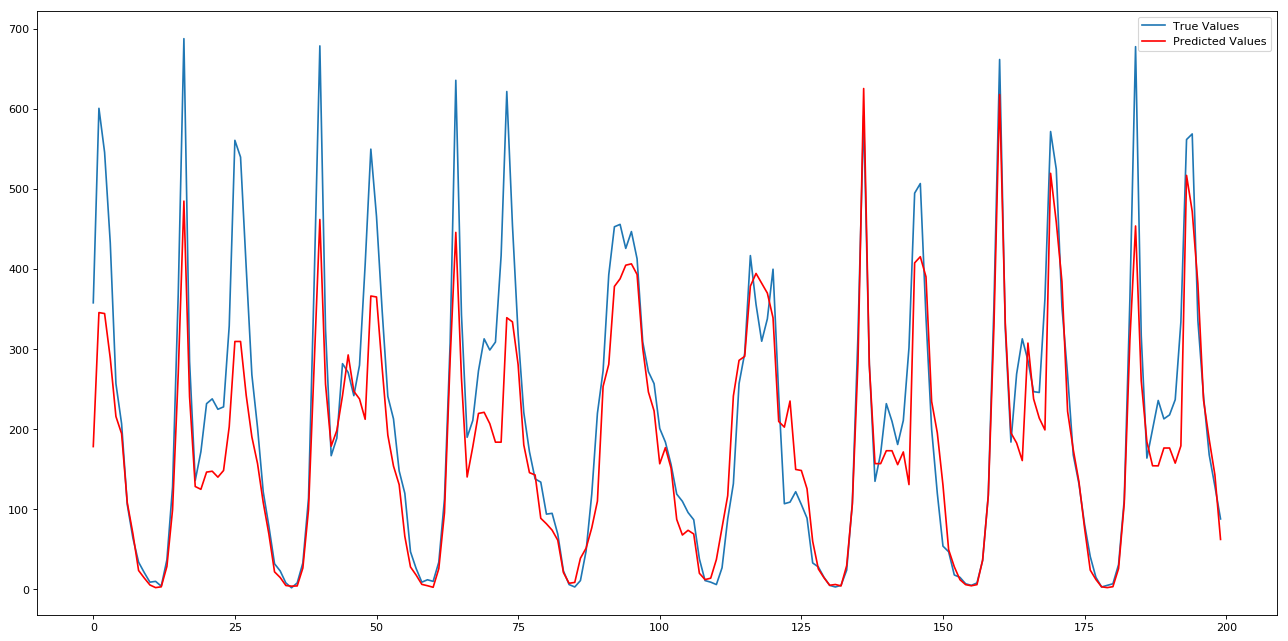

In [209]:
from matplotlib import pyplot as plt
figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

view_number=200
index = [x for x in range(len(y_test))]
plt.plot(y_test.values[-view_number:], label='True Values')
plt.plot(test_predictions[-view_number:], c='r', label='Predicted Values')
plt.legend()

![](../readme_images/7.png)

### Building an API

![](http://blog.restcase.com/content/images/2016/11/api-collaboration.png)

An application programming interface is an interface or communication protocol between a client and a server intended to simplify the building of client-side software.

![](../readme_images/10.png)

### Exporting Model

In [211]:
import pickle
import os

# pickle.dump(rf_model,open("../models/rf_model.pkl",'wb'))

In [212]:
loaded_model = pickle.load(open("../models/rf_model.pkl",'rb'))
result = loaded_model.predict(x_train[-1:])
result

array([561.6])

In [213]:
x_train[-1:]

,season,holiday,workingday,weather,temp,humidity,windspeed,hour,year,weekday,month
7840,3,0,0,1,31.16,40,12.998,14,2012,6,8


In [215]:
y_train[-1:]

7840    579
Name: count, dtype: int64

![](../readme_images/9.png)

### Containerization

![](../readme_images/8.png)

![](../readme_images/11.png)

![](../readme_images/12.png)

### Container Orchestration

![](../readme_images/13.png)

![](../readme_images/14.png)